# 🌍 linear Regression for Carbon-Footprint 🌿 

### Table of Contents
1. loading data
2. Exploratory Data Analysis (EDA)
   1. Feature Categorization
   2. Data Exploration and Summary
   3. Correlation Analysis of Transport-Related Variables
3. Data Preprocessing
   1. Handling Missing Data
   2. Data validation
   3. encoding and scaling
4. model: linear regression
   1. Model Training and Evaluation
   2. Model Saving in pkl-format
   3. Regression Equation
   4. Regression Coefficients
   5. prediction

# 1. Importing the dataset and libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


df=pd.read_csv('Carbon_Emission.csv',sep=";")

#df = pd.read_csv('/kaggle/input/individual-carbon-footprint-calculation/Carbon Emission.csv')
#data can be found at https://www.kaggle.com/datasets/dumanmesut/individual-carbon-footprint-calculation/data


# change display settings to show all columns
pd.set_option('display.max_columns', None)


#rename
# rename columns: replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')
# data.columns = data.columns.str.replace(' ', '_').str.lower()
# Rename 'public' to 'public transport' and the car-typs - to make the information easier to understand
df['Vehicle_Type'] = df['Vehicle_Type'].replace({'public': 'public transport', 'petrol': 'car (type: petrol)','diesel': 'car (type: diesel)',
                                                'hybrid': 'car (type: hybrid)','lpg': 'car (type: lpg)','electric': 'car (type: electric)'})
df['Transport'] = df['Transport'].replace({'public': 'public transport', 'private': 'car'})


df.head()

,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,car,car (type: petrol),never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,car,car (type: diesel),often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


# 2. Exploratory Data Analysis (EDA)

## 2.1 Feature Categorization


| variable type |  variables in this example | scaling & encoding |
| ------------- | :----------- | :-----------: |
|dependent variable |  CarbonEmission |   |
|Quantitative Variables |  Monthly Grocery Bill, Vehicle Monthly Distance Km, Waste Bag Weekly Count, How Long TV, PC Daily, Hour How Many New Clothes Monthly, How Long Internet Daily Hour | MinMaxScaler |
| Ordinal Variables |  Body_Type, Diet, How_Often_Shower, Social_Activity, Frequency_of_Traveling_by_Air, Waste_Bag_Size, Energy_efficiency | OneHotEncoder. with drop first column |
| Nominal Variables, with one answer |  'Sex', 'Heating_Energy_Source'. For 'Transport', 'Vehicle Type' we will combine the information of these two columns into one new column 'Transport_Vehicle_Type' | OneHotEncoder. with drop first column |
| Nominal Variables, with multiple (or zero) answers | Recycling, Cooking_With | make dummy-variables and don't drop first column  |


In [2]:

variables_ordinal = ['Body_Type','Diet','How_Often_Shower','Social_Activity','Frequency_of_Traveling_by_Air','Waste_Bag_Size','Energy_efficiency']
variables_nominal_1answer = ['Sex', 'Heating_Energy_Source','Transport_Vehicle_Type']
variables_for_one_hot_encoded = variables_ordinal + variables_nominal_1answer 
#variables_for_one_hot_encoded =df.select_dtypes(include=['object','category']).drop(['Transport','Vehicle_Type','Recycling','Cooking_With'],axis=1).columns.tolist()


#variables_quantitative =df.select_dtypes(include=[np.number]).drop('CarbonEmission',axis=1).columns.tolist()
variables_quantitative = ['Monthly_Grocery_Bill', 'Vehicle_Monthly_Distance_Km', 'Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour']


In [3]:
#test if the lists above contain all columns or if I forgot some

all_columns=set(["Recycling" ,"Cooking_With"]).union(
    ['Transport','Vehicle_Type'],
    variables_quantitative,
    variables_for_one_hot_encoded,
    ["CarbonEmission"])

assert all_columns  == set(df.columns.tolist() + ['Transport_Vehicle_Type'])

### 2.1.1 Ordering of Ordinal Variables

In [4]:
#ordering values of ordinal variables

# dictonary of ordinal categorical variables. perpose of this dictonary: values of categorical variables can be ordered
dict_variables_ordinal_categorical = {
    'Body_Type': ['underweight', 'normal', 'overweight', 'obese'],
    'Diet': ['vegan','vegetarian','pescatarian','omnivore'],
    'How_Often_Shower': ['less frequently','daily', 'twice a day','more frequently'],
    'Social_Activity': ['never', 'sometimes','often'],
    'Frequency_of_Traveling_by_Air': ['never', 'rarely', 'frequently', 'very frequently'],
    'Waste_Bag_Size': ['small','medium', 'large', 'extra large'],
    'Energy_efficiency': ['Yes', 'Sometimes', 'No']
}
#Kategorien definieren: Verwende pd.Categorical, um die values von ordinal categorical variables in der gewünschten Reihenfolge zu definieren. Die Option ordered=True stellt sicher, dass die Kategorien als geordnet behandelt werden.
for column, col_ordering in dict_variables_ordinal_categorical.items():
    df[column] = pd.Categorical(df[column], categories=col_ordering, ordered=True)   #chatGPT did the programming for me

#example
df['Waste_Bag_Size'].unique()

['large', 'extra large', 'small', 'medium']
Categories (4, object): ['small' < 'medium' < 'large' < 'extra large']

## 2.2. Data Exploration and Summary

In [5]:
#values of the variables
# As this dataset has many columns, for gaining better understanding on the data we have to take a look at their unique values


# Berechnet den maximalen Wert einer Spalte, wenn sie numerisch ist       # I don't programm that - chatGPT did
def max_value(column):
    if pd.api.types.is_numeric_dtype(column):  # Überprüfe, ob der Datentyp numerisch ist
        return column.dropna().max() if not column.dropna().empty else np.nan
    return ""

# gibt Range zurück (falls es eine gibt),   Gibt die einzigartigen Werte einer Spalte zurück, oder eine Range (falls es eine gibt)    # I don't programm that - chatGPT did
# I don't programm that - chatGPT did
def get_unique_values(column):
    if pd.api.types.is_integer_dtype(column):  # Überprüfe, ob der Datentyp eine Ganzzahl ist
        unique_vals = sorted(set(column.dropna()))
        min_val, max_val = column.min(), column.max()
        if unique_vals == list(range(min_val, max_val + 1)):
            return f"range({min_val},{max_val + 1})"
        return unique_vals
#        return f"between {min_val} and {max_val}"
    elif isinstance(column.dtype, pd.CategoricalDtype):  # Überprüfe, ob der Datentyp eine Kategorie ist
        return list(column.cat.categories)
    return sorted(set(column.dropna())) #wenn Datentyp weger ganzzahlig noch Categorie ist


# Erstelle ein DataFrame zur grundlegender EDA
summary_df = pd.DataFrame({
    'data type': df.dtypes,                                                     # Datentypen jeder Spalte
    'missing data': df.isna().sum(),                                            # Anzahl fehlender Daten in jeder Spalte
    'unique values': [get_unique_values(df[col]) for col in df.columns],        # Liste der einzigartigen Werte in jeder Spalte, sortiert und ohne NaNs
#   'unique values': [sorted(df[col].dropna().unique()) for col in df.columns], # Liste der einzigartigen Werte in jeder Spalte, sortiert und ohne NaNs
    'max value': [max_value(df[col]) for col in df.columns],
    'number of unique values': df.nunique()                                     # Anzahl einzigartiger Werte in jeder Spalte
})


# Sortiere nach 'data type' und dann nach 'number of unique values'
summary_df['data type'] = summary_df['data type'].astype(str)  # Konvertiere 'data type' zu String, um Vergleichsprobleme zu vermeiden
summary_df = summary_df.sort_values(by=['data type', 'number of unique values'])

summary_df

,data type,missing data,unique values,max value,number of unique values
Social_Activity,category,0,"[never, sometimes, often]",,3
Energy_efficiency,category,0,"[Yes, Sometimes, No]",,3
Body_Type,category,0,"[underweight, normal, overweight, obese]",,4
Diet,category,0,"[vegan, vegetarian, pescatarian, omnivore]",,4
How_Often_Shower,category,0,"[less frequently, daily, twice a day, more fre...",,4
Frequency_of_Traveling_by_Air,category,0,"[never, rarely, frequently, very frequently]",,4
Waste_Bag_Size,category,0,"[small, medium, large, extra large]",,4
Waste_Bag_Weekly_Count,int64,0,"range(1,8)",7,7
How_Long_TV_PC_Daily_Hour,int64,0,"range(0,25)",24,25
How_Long_Internet_Daily_Hour,int64,0,"range(0,25)",24,25


In [6]:

data = []

# For-Schleife, um Daten zu sammeln
for headline in ["Recycling" ,"Cooking_With"]:  
    unique_values= set([item for sublist in df[headline].unique() for item in eval(sublist)]) #eval - Convert string representation of list to an actual list
    # Erstellen eines Dictionaries für jede Zeile
    row = {
        'column': headline, 
        'unique values': unique_values, 
        'number of unique values': len(unique_values)
    }
    data.append(row)

# Umwandeln der Liste von Dictionaries in ein DataFrame
pd.DataFrame(data)

,column,unique values,number of unique values
0,Recycling,"{Plastic, Metal, Paper, Glass}",4
1,Cooking_With,"{Grill, Stove, Oven, Microwave, Airfryer}",5


## 2.3 Distribution of quantitative variables

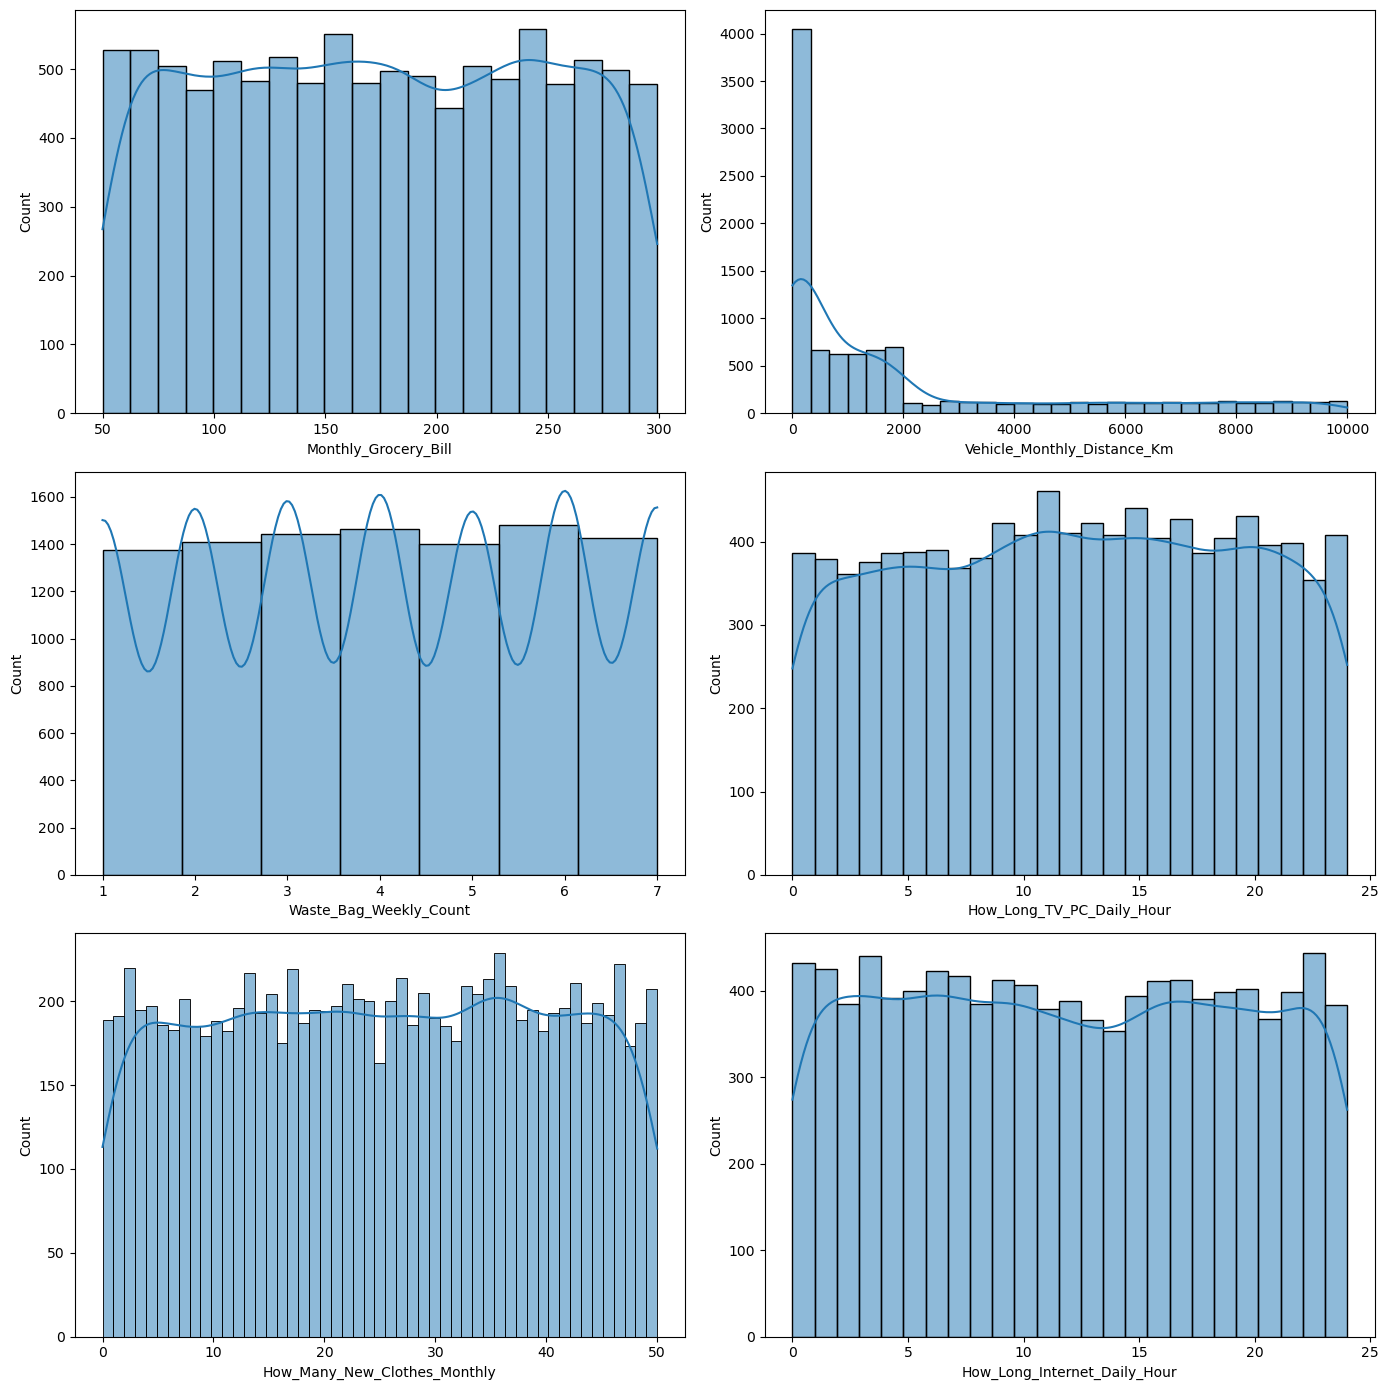

In [14]:

# Anpassen der Größe des gesamten Diagramms
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))


# Schleife zur Erstellung der Verteilungsplots für jede quantitative Variable
for idx, col_name in enumerate(variables_quantitative):
    # Bestimme die aktuelle Achse für den Plot
    ax = axes[idx // 2, idx % 2]

    # Bestimme die Anzahl der Bins je nach Spalte
    if col_name == 'Monthly_Grocery_Bill':
        bins = 20
    elif col_name == 'Vehicle_Monthly_Distance_Km':
        bins = 30 
    else: # Standardwert für alle anderen Spalten
        bins = df[col_name].nunique()  #range ihrer angenommen Werte
    
    # Verteilungsplot für die aktuelle Spalte auf der zugewiesenen Achse
    sns.histplot(df[col_name], kde=True, ax=ax, bins=bins)  #kde=True - um die KDE-Kurve zu erhalten.
 
    # Setze den Titel der Achse auf den Namen der Spalte
    #ax.set_title(f'Distribution of {col_name}')

# Layout-Anpassungen, um Überlappungen zu vermeiden
plt.tight_layout()

# Zeige die Diagramme an
plt.show()


## 2.4. Correlation Analysis of Transport-Related Variables

In [7]:
# Make copy to avoid changing original data 
df_corr=df[['CarbonEmission','Vehicle_Monthly_Distance_Km','Transport','Vehicle_Type']].copy()

#    df_corr[str(item)] = df_corr['Transport'].apply(lambda x: 1 if item in x else 0)
# 'male' in 'female' -> male-colum = 1, 

##create dummy-variables for correlation metric: 
for item in df_corr['Transport'].unique():
    df_corr[str(item)] = df_corr['Transport'].apply(lambda x: 1 if item == x else 0)

#unique_vehicle_types = df_corr['Vehicle_Type'].unique() #NaN is in the list
unique_vehicle_types = list(pd.Series(df_corr['Vehicle_Type'].unique()).dropna().unique()) #NaN is not in the list
for item in unique_vehicle_types:
    df_corr[str(item)] = df_corr['Vehicle_Type'].apply(lambda x: 1 if item == x else 0)

df_corr

,CarbonEmission,Vehicle_Monthly_Distance_Km,Transport,Vehicle_Type,public transport,walk/bicycle,car,car (type: petrol),car (type: diesel),car (type: hybrid),car (type: lpg),car (type: electric)
0,2238,210,public transport,NaN,1,0,0,0,0,0,0,0
1,1892,9,walk/bicycle,NaN,0,1,0,0,0,0,0,0
2,2595,2472,car,car (type: petrol),0,0,1,1,0,0,0,0
3,1074,74,walk/bicycle,NaN,0,1,0,0,0,0,0,0
4,4743,8457,car,car (type: diesel),0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2408,268,car,car (type: hybrid),0,0,1,0,0,1,0,0
9996,3084,5316,car,car (type: lpg),0,0,1,0,0,0,1,0
9997,2377,96,walk/bicycle,NaN,0,1,0,0,0,0,0,0
9998,4574,8688,car,car (type: petrol),0,0,1,1,0,0,0,0


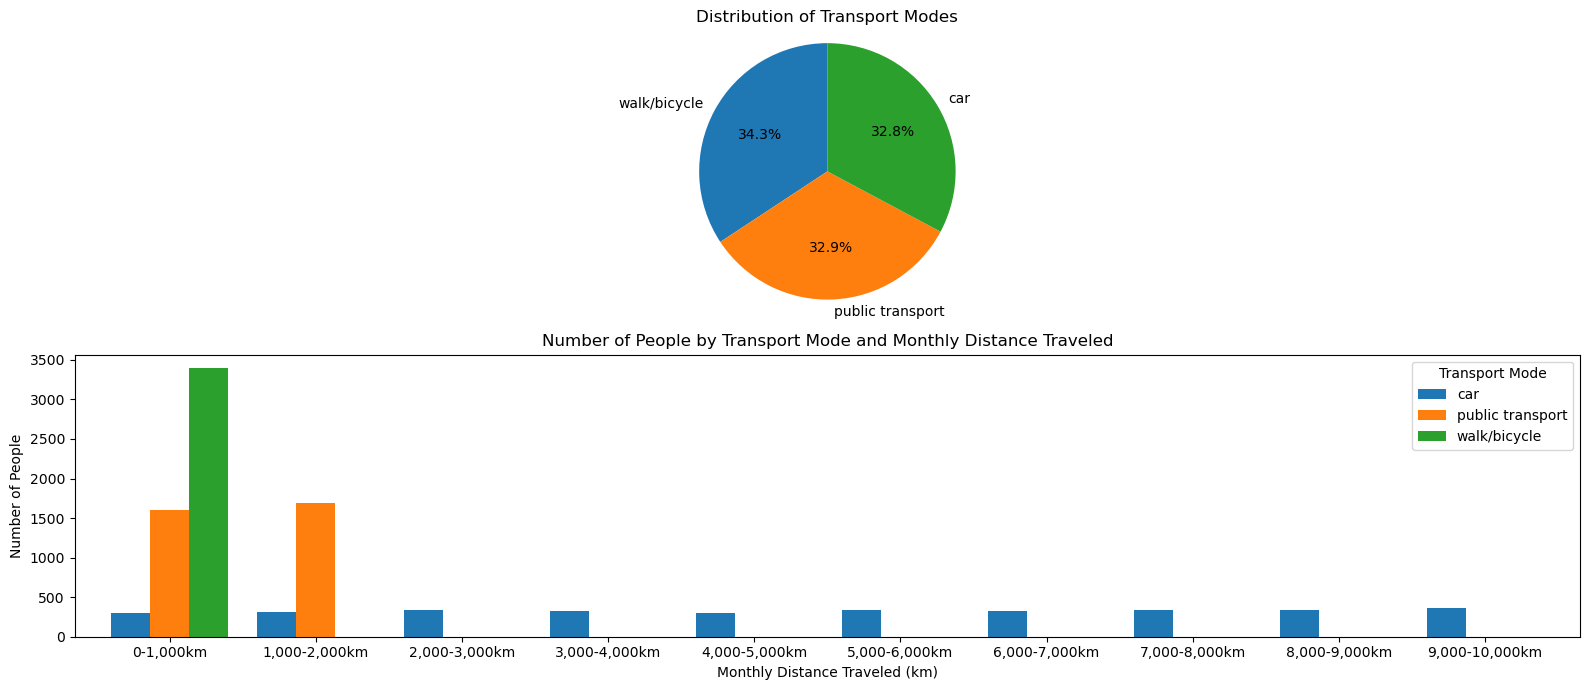

In [8]:
#chatGPT wrote the code for me


import pandas as pd
import matplotlib.pyplot as plt

# Distribution of transport modes
transport_counts = df_corr['Transport'].value_counts()
labels = [label for label in transport_counts.index]
sizes = transport_counts.values

# Create categories for Vehicle_Monthly_Distance_Km with 10 bins
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
distance_labels = ["0-1,000km", "1,000-2,000km", "2,000-3,000km", "3,000-4,000km", "4,000-5,000km", 
                   "5,000-6,000km", "6,000-7,000km", "7,000-8,000km", "8,000-9,000km", "9,000-10,000km"]
df_corr['Distance_Category'] = pd.cut(df_corr['Vehicle_Monthly_Distance_Km'], bins=bins, labels=distance_labels)

# Calculate the distribution of transport modes within each Distance_Category
counts = df_corr.groupby(['Distance_Category', 'Transport'], observed=True).size().unstack(fill_value=0)

# Create the combined plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 7))


# Pie chart
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title("Distribution of Transport Modes")

# Bar plot
counts.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Number of People by Transport Mode and Monthly Distance Traveled')
axes[1].set_xlabel('Monthly Distance Traveled (km)')
axes[1].set_ylabel('Number of People')
axes[1].legend(title='Transport Mode')
plt.xticks(rotation=0)


# Show the combined plot
plt.tight_layout()
plt.show()


/var/folders/9l/ng7prn7d7z1gpmzs8nj4klgm0000gn/T/ipykernel_14927/623801153.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y='Transport', x='Vehicle_Monthly_Distance_Km', data=df_corr, palette="Set2")


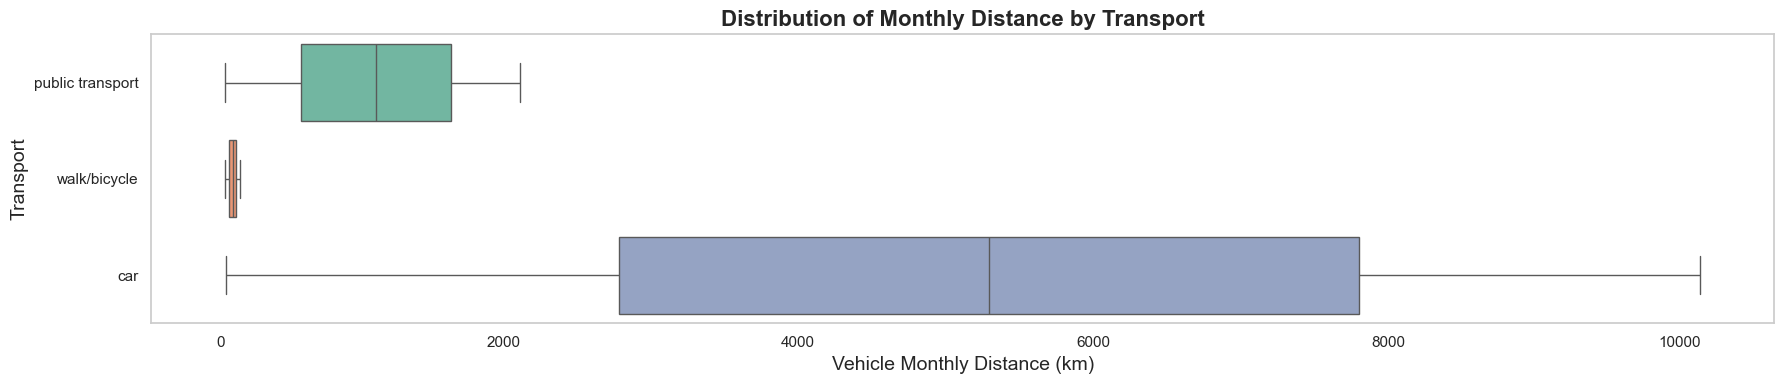

In [9]:
#chatGPT wrote the code for me


import matplotlib.pyplot as plt
import seaborn as sns

# Create the boxplot
plt.figure(figsize=(18, 4))  # Increase height for better readability
sns.set(style="whitegrid")  # Set background style to "whitegrid"

# Create the boxplot with color palette
ax = sns.boxplot(y='Transport', x='Vehicle_Monthly_Distance_Km', data=df_corr, palette="Set2")

# Add title and axis labels
plt.title('Distribution of Monthly Distance by Transport', fontsize=16, weight='bold')
plt.xlabel('Vehicle Monthly Distance (km)', fontsize=14)
plt.ylabel('Transport', fontsize=14)

# Remove grid lines
ax.grid(False)

# Rotate X-axis labels for better readability
plt.xticks(rotation=0, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

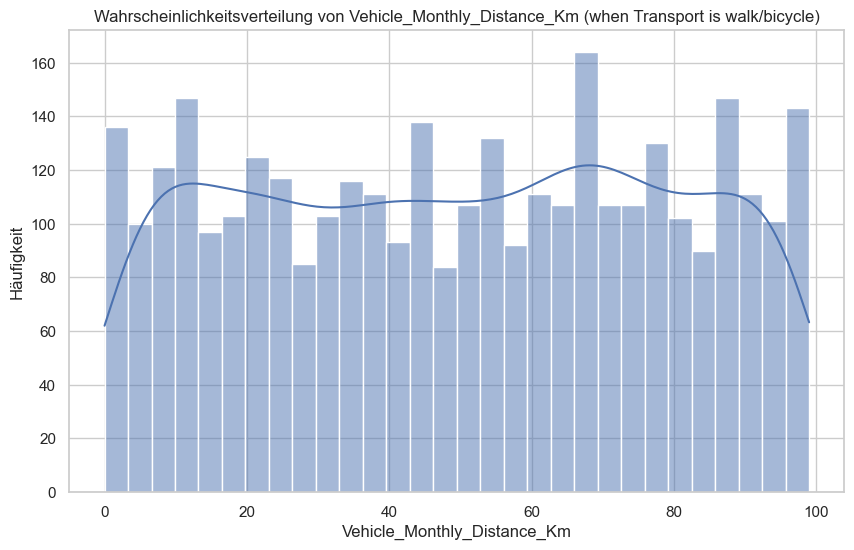

count    3427.000000
mean       49.770937
std        29.142378
min         0.000000
25%        24.000000
50%        50.000000
75%        75.000000
max        99.000000
Name: Vehicle_Monthly_Distance_Km, dtype: float64

In [10]:
#chatGPT did the programming
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Daten filtern
filtered_data = df_corr[df_corr['Transport'] == 'walk/bicycle']

# Statistische Beschreibung
description = filtered_data['Vehicle_Monthly_Distance_Km'].describe()

# Visualisierung
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['Vehicle_Monthly_Distance_Km'], kde=True, bins=30)
plt.title('Wahrscheinlichkeitsverteilung von Vehicle_Monthly_Distance_Km (when Transport is walk/bicycle)')
plt.xlabel('Vehicle_Monthly_Distance_Km')
plt.ylabel('Häufigkeit')
plt.show()

description

In [11]:
#chatGPT did the programming

import pandas as pd

# Daten filtern und NaN/inf Werte handhaben
filtered_data = df_corr[df_corr['Transport'] == 'walk/bicycle']
filtered_data = filtered_data.dropna(subset=['Vehicle_Monthly_Distance_Km'])

# Häufigkeiten berechnen
distance_counts = filtered_data['Vehicle_Monthly_Distance_Km'].value_counts().reset_index()
distance_counts.columns = ['Vehicle_Monthly_Distance_Km', 'Count (when Transport is walk/bicycle)']

# Neues DataFrame anzeigen
distance_counts

,Vehicle_Monthly_Distance_Km,Count (when Transport is walk/bicycle)
0,92,55
1,7,51
2,69,50
3,24,48
4,98,47
...,...,...
95,55,24
96,84,24
97,36,23
98,23,23


In [12]:
#chatGPT did the programming

import pandas as pd

# Daten filtern und NaN/inf Werte handhaben
filtered_data = df_corr[df_corr['Transport'] == 'public transport']
filtered_data = filtered_data.dropna(subset=['Vehicle_Monthly_Distance_Km'])

# Häufigkeiten berechnen
distance_counts = filtered_data['Vehicle_Monthly_Distance_Km'].value_counts().reset_index()
distance_counts.columns = ['Vehicle_Monthly_Distance_Km', 'Count (when Transport is walk/bicycle)']

# Neues DataFrame anzeigen
distance_counts

,Vehicle_Monthly_Distance_Km,Count (when Transport is walk/bicycle)
0,1507,7
1,1046,7
2,520,6
3,1159,6
4,1886,6
...,...,...
1585,1496,1
1586,785,1
1587,991,1
1588,1771,1


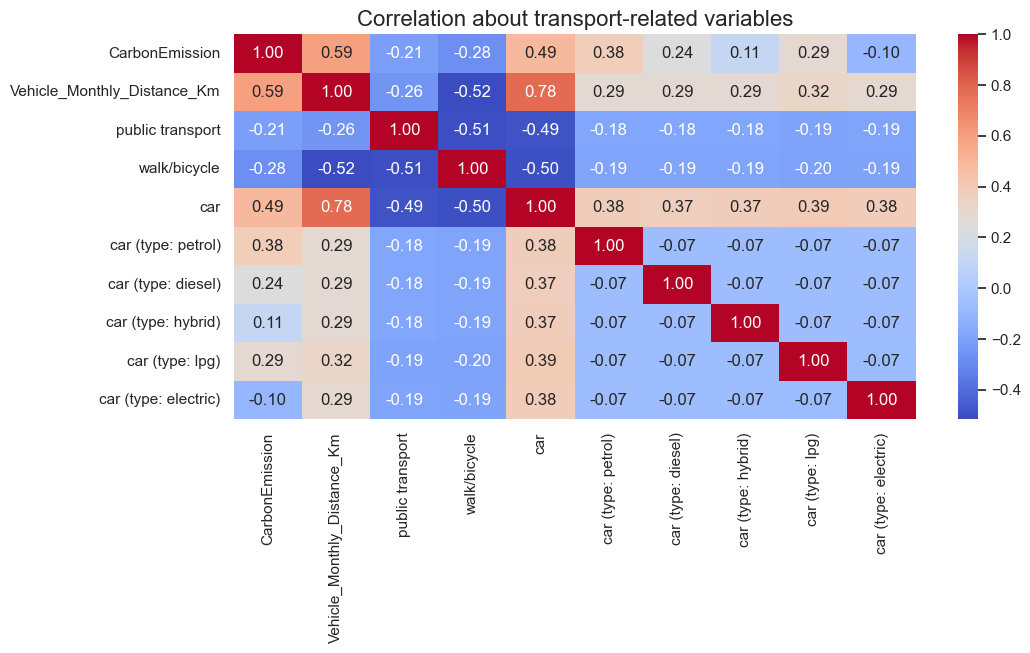

In [13]:
#correlation metric
import matplotlib.pyplot as plt

#correlations = df[column_for_correlation].corr()
correlation_metric = df_corr[['CarbonEmission', 'Vehicle_Monthly_Distance_Km', 'public transport', 'walk/bicycle', 'car',
       'car (type: petrol)', 'car (type: diesel)', 'car (type: hybrid)','car (type: lpg)', 'car (type: electric)']].corr()
plt.figure(figsize=(11, 5))  #size of figure
sns.heatmap(correlation_metric, cmap="coolwarm", annot=True, fmt='.2f') #fmt='.2f' macht 2 Nachkommerstellen  #cmap=sns.cubehelix_palette(as_cmap=True) - die Farben finde ich schlecht
plt.title('Correlation about transport-related variables', fontsize=16)
plt.show()

there is a high correlation of:
* -0.52 between 'Vehicle_Monthly_Distance_Km' and 'Transport: walk/bicycle'. It makes sense that walking persons don't travel many km each month and that a person who has only a short distance to travel might walk
* 0.78 between 'Vehicle_Monthly_Distance_Km' and 'Transport: car'.

Due to the correlation between the variables 'Vehicle_Monthly_Distance_Km' and 'Transport' a linear Regression (where we want to use both variables) might not be best model  - but we will do it anyway

# 3. Data Preprocessing

## 3.1 Handling Missing Data

**I want to combined information of the variables "Transport" and "Vehicle Type" into a new one column "Transport_Vehicle_Type" to get rid of the NaN-entries in "Vehicle Type"**

In [14]:
#there are NaN-entries in "Vehicle Type"
df.isna().sum()

Body_Type                           0
Sex                                 0
Diet                                0
How_Often_Shower                    0
Heating_Energy_Source               0
Transport                           0
Vehicle_Type                     6721
Social_Activity                     0
Monthly_Grocery_Bill                0
Frequency_of_Traveling_by_Air       0
Vehicle_Monthly_Distance_Km         0
Waste_Bag_Size                      0
Waste_Bag_Weekly_Count              0
How_Long_TV_PC_Daily_Hour           0
How_Many_New_Clothes_Monthly        0
How_Long_Internet_Daily_Hour        0
Energy_efficiency                   0
Recycling                           0
Cooking_With                        0
CarbonEmission                      0
dtype: int64

In [15]:
##test

#test: if "Transport"=="public transport" then "Vehicle Type"==NaN
assert df[df["Transport"]=="public"]["Vehicle_Type"].isna().all()  #wenn in der Liste alle True sind, kommt ein True raus dh stellt sicher das alle true sind #assert tut gar nichts bei True aber bei False macht Fehlermeldung und hört auf

#test: if "walk/bicycle" then "Vehicle Type"==NaN
assert df[df["Transport"]=="walk/bicycle"]["Vehicle_Type"].isna().all()  #wenn in der Liste alle True sind, kommt ein True raus dh stellt sicher das alle true sind #assert tut gar nichts bei True aber bei False macht Fehlermeldung und hört auf

#test: if "Transport"=="private" then "Vehicle Type"!=NaN
assert not ((df["Transport"]=="private") & (df["Vehicle_Type"].isna())).any() #any weil gibt es irgendein True? False heißt es gibt kein einziges True

In [16]:
##create new column "Transport Vehicle Type" 
df["Transport_Vehicle_Type"]=df["Vehicle_Type"] #create a new column
df.loc[df["Transport_Vehicle_Type"].isna(), "Transport_Vehicle_Type"] = df["Transport"] # Werte aus 'Transport' übernehmen, wenn 'Vehicle Type' NaN ist


##add "Transport Vehicle Type" to one-hot-encoding-list
if "Transport_Vehicle_Type" not in variables_for_one_hot_encoded: ##wenn es noch nicht hinzugefügt wurde bzw is one element in the list already?
    variables_nominal_1answer.append("Transport_Vehicle_Type") 

##veranschaulichen der neuen Spalten und ihrer Werte
df[["Transport","Vehicle_Type","Transport_Vehicle_Type"]].head()

,Transport,Vehicle_Type,Transport_Vehicle_Type
0,public transport,NaN,public transport
1,walk/bicycle,NaN,walk/bicycle
2,car,car (type: petrol),car (type: petrol)
3,walk/bicycle,NaN,walk/bicycle
4,car,car (type: diesel),car (type: diesel)


In [17]:
#Zusammenfassung welche Werte die mehreren Spalten ist

print(df.groupby(["Transport","Vehicle_Type","Transport_Vehicle_Type"]).size()) #ich GLAUBE das problem ist: Python lässt die mit "NaN" unter dem Tisch fallen

pd.DataFrame(df.groupby(["Transport","Transport_Vehicle_Type"]).size())

Transport  Vehicle_Type          Transport_Vehicle_Type
car        car (type: diesel)    car (type: diesel)        622
           car (type: electric)  car (type: electric)      671
           car (type: hybrid)    car (type: hybrid)        642
           car (type: lpg)       car (type: lpg)           697
           car (type: petrol)    car (type: petrol)        647
dtype: int64


0
Transport        Transport_Vehicle_Type      
car              car (type: diesel)       622
                 car (type: electric)     671
                 car (type: hybrid)       642
                 car (type: lpg)          697
                 car (type: petrol)       647
public transport public transport        3294
walk/bicycle     walk/bicycle            3427

## 3.2 Data Validation

in simulating the data set the creators seemed to have linked the use of a cooking with grill and the use of an airfryer. Consequently, we excluded the airfryer from the variables, as it did not contain any additional information. We found this out by doing a correlation matrix for the dummy-variables.

In [18]:

#create dummy-variables for "Cooking With":
df2 = df[['Cooking_With']].copy()
df2['Cooking_With_Grill'] = df2['Cooking_With'].apply(lambda x: 1 if "Grill" in x else 0)
df2['Cooking_With_Airfryer'] = df2['Cooking_With'].apply(lambda x: 1 if "Airfryer" in x else 0)


#what are the values for the variables "Cooking With Airfryer","Cooking With Grill"
print(df2.groupby(["Cooking_With_Airfryer","Cooking_With_Grill"]).size())

#correlation metrics
print(df2[["Cooking_With_Grill", "Cooking_With_Airfryer"]].corr())

#therefore we don't create a dummy-variable "Cooking_With_Airfryer" above

Cooking_With_Airfryer  Cooking_With_Grill
0                      0                     5008
1                      1                     4992
dtype: int64
                       Cooking_With_Grill  Cooking_With_Airfryer
Cooking_With_Grill                    1.0                    1.0
Cooking_With_Airfryer                 1.0                    1.0


In [19]:

# Remove "Airfryer" from the 'Cooking_With'-variable
df['Cooking_With'] = df['Cooking_With'].str.replace(", 'Airfryer'", "") 

# Check if the removal was successful
unique_values_cooking_With= set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]) # Create a set of all unique "Cooking_With" options
print(unique_values_cooking_With)   

{'Grill', 'Stove', 'Oven', 'Microwave'}


## 3.3 OneHotEncoding for Multi-Select Features ("Recycling" and "Cooking_With")

In [20]:
import ast

#Quelle: https://www.kaggle.com/code/azamatjonkhasanzoda/carbon-eda-viz-clustering

# Convert the 'Recycling' and 'Cooking_With' columns from string representations of lists to actual lists
df['Recycling2'] = df['Recycling'].apply(ast.literal_eval)
df['Cooking_With2'] = df['Cooking_With'].apply(ast.literal_eval)

df.head()

for element in df['Cooking_With2'][0]:
    print(element)

#df['Cooking_With2'][0].dtype #hier ist list
#df['Cooking_With'][0].dtype #hier ist string


Stove
Oven


In [21]:

# Function to create dummy variables for a given column that has multi-select features
def create_dummy_variables(df, column_name):

    # Extract unique values from the column
    unique_values = {item for sublist in df[column_name].unique() for item in eval(sublist)}
    
    # Create dummy variables for each unique value
    for item in unique_values:
        df[f'{column_name}_{item}'] = df[column_name].apply(lambda x: 1 if item in x else 0)
    
    return unique_values


# 1.) Generate dummy variables for Recycling and Cooking_With columns and 2.) save the unique-value in this list
unique_values_recycling = create_dummy_variables(df, 'Recycling')
unique_values_cooking_with = create_dummy_variables(df, 'Cooking_With')


# Create a list of dummy variable column names for Regression
dummy_variables=set()
dummy_variables.update([f'Recycling_{item}' for item in unique_values_recycling])
dummy_variables.update([f'Cooking_With_{item}' for item in unique_values_cooking_with])

#############
#Person 282 cooks with "nothing" deshalb can bei one-hot-encoding nicht eine Spalte gelöscht werden, person 283 who doesn't recycle deshalb can bei one-hot-encoding nicht eine Spalte gelöscht werden
#view the dummy variables
df.loc[282:283, ['Recycling', 'Cooking_With'] + list(df.columns[-9:])]

,Recycling,Cooking_With,Cooking_With2,Recycling_Plastic,Recycling_Metal,Recycling_Paper,Recycling_Glass,Cooking_With_Grill,Cooking_With_Stove,Cooking_With_Oven,Cooking_With_Microwave
282,"['Paper', 'Plastic', 'Metal']",[],[],1,1,1,0,0,0,0,0
283,[],"['Stove', 'Grill']","[Stove, Grill]",0,0,0,0,1,1,0,0


## 3.4 Encoding & Scaling - ColumnTransformer

In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

dummy_variables = sorted(list(dummy_variables))
X = df[variables_ordinal + variables_nominal_1answer + variables_quantitative + dummy_variables]  


print(len(variables_ordinal)+ len(variables_nominal_1answer),"Features for One-Hot-Encoding:")
print("-", len(variables_ordinal),"ordinal variables:",variables_ordinal)
print("-", len(variables_nominal_1answer),"nominal variables with one answer:",variables_nominal_1answer)
print(len(variables_quantitative),"Features for Min-Max-Scalering:\n",variables_quantitative)
print(len(dummy_variables),"Features where we already have dummy-variables:\n",dummy_variables)




# Create the ColumnTransformer using the list "variables_for_one_hot_encoded"
cf = ColumnTransformer(
    [(col, OneHotEncoder(drop="first"), [col]) for col in variables_ordinal] +
    [(col, OneHotEncoder(drop="first"), [col]) for col in variables_nominal_1answer] +
    [(col, MinMaxScaler(), [col]) for col in variables_quantitative],  
    remainder="passthrough")


cf.fit(X)
X_transformed = cf.transform(X) # Data after scaling



cf 

10 Features for One-Hot-Encoding:
- 7 ordinal variables: ['Body_Type', 'Diet', 'How_Often_Shower', 'Social_Activity', 'Frequency_of_Traveling_by_Air', 'Waste_Bag_Size', 'Energy_efficiency']
- 3 nominal variables with one answer: ['Sex', 'Heating_Energy_Source', 'Transport_Vehicle_Type']
6 Features for Min-Max-Scalering:
 ['Monthly_Grocery_Bill', 'Vehicle_Monthly_Distance_Km', 'Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour']
8 Features where we already have dummy-variables:
 ['Cooking_With_Grill', 'Cooking_With_Microwave', 'Cooking_With_Oven', 'Cooking_With_Stove', 'Recycling_Glass', 'Recycling_Metal', 'Recycling_Paper', 'Recycling_Plastic']


/opt/homebrew/Caskroom/miniforge/base/envs/elisabeth_python-umgebung_nr1/lib/python3.11/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('Body_Type', OneHotEncoder(drop='first'),
                                 ['Body_Type']),
                                ('Diet', OneHotEncoder(drop='first'), ['Diet']),
                                ('How_Often_Shower',
                                 OneHotEncoder(drop='first'),
                                 ['How_Often_Shower']),
                                ('Social_Activity', OneHotEncoder(drop='first'),
                                 ['Social_Activity']),
                                ('Frequency_of_Traveling_by_Air',
                                 OneHotEncoder(drop='f...
                                ('Vehicle_Monthly_Distance_Km', MinMaxScaler(),
                                 ['Vehicle_Monthly_Distance_Km']),
                                ('Waste_Bag_Weekly_Count', MinMaxScaler(),
                                 ['Waste_Bag_Weekly_Count']),
                                ('How_Long_TV_PC_Daily_Hour', MinMaxScaler(),
                                 ['How_Long_TV_PC_Daily_Hour']),
                                ('How_Many_New_Clothes_Monthly', MinMaxScaler(),
                                 ['How_Many_New_Clothes_Monthly']),
                                ('How_Long_Internet_Daily_Hour', MinMaxScaler(),
                                 ['How_Long_Internet_Daily_Hour'])])

In [23]:
#to get a better understanding of the code


# Get the feature names after one-hot encoding. I do NOT understand that - chatGTP did the programming
ohe_feature_names = []
for col, transformer, _ in cf.transformers_[:-1]:
    ohe_feature_names.extend(transformer.get_feature_names_out([col]))
    
# ColumnTransformer removed column names; put them back and transform from array to DataFrame
X_transformed = pd.DataFrame(X_transformed, columns=ohe_feature_names + dummy_variables)
X_transformed

,Body_Type_obese,Body_Type_overweight,Body_Type_underweight,Diet_pescatarian,Diet_vegan,Diet_vegetarian,How_Often_Shower_less frequently,How_Often_Shower_more frequently,How_Often_Shower_twice a day,Social_Activity_often,Social_Activity_sometimes,Frequency_of_Traveling_by_Air_never,Frequency_of_Traveling_by_Air_rarely,Frequency_of_Traveling_by_Air_very frequently,Waste_Bag_Size_large,Waste_Bag_Size_medium,Waste_Bag_Size_small,Energy_efficiency_Sometimes,Energy_efficiency_Yes,Sex_male,Heating_Energy_Source_electricity,Heating_Energy_Source_natural gas,Heating_Energy_Source_wood,Transport_Vehicle_Type_car (type: electric),Transport_Vehicle_Type_car (type: hybrid),Transport_Vehicle_Type_car (type: lpg),Transport_Vehicle_Type_car (type: petrol),Transport_Vehicle_Type_public transport,Transport_Vehicle_Type_walk/bicycle,Monthly_Grocery_Bill,Vehicle_Monthly_Distance_Km,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Cooking_With_Grill,Cooking_With_Microwave,Cooking_With_Oven,Cooking_With_Stove,Recycling_Glass,Recycling_Metal,Recycling_Paper,Recycling_Plastic
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.722892,0.021002,0.500000,0.291667,0.52,0.041667,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.257028,0.000900,0.333333,0.375000,0.76,0.208333,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.353414,0.247225,0.000000,0.583333,0.94,0.250000,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.429719,0.007401,0.333333,0.833333,0.10,0.291667,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.867470,0.845785,0.000000,0.125000,0.10,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.722892,0.026803,0.666667,0.500000,0.54,0.375000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.738956,0.531653,0.333333,0.583333,0.16,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
9997,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.995984,0.009601,0.666667,0.458333,0.10,1.000000,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
9998,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.518072,0.868887,0.666667,0.791667,0.28,0.208333,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0


In [24]:
#to get a better understanding of the code
X

,Body_Type,Diet,How_Often_Shower,Social_Activity,Frequency_of_Traveling_by_Air,Waste_Bag_Size,Energy_efficiency,Sex,Heating_Energy_Source,Transport_Vehicle_Type,Monthly_Grocery_Bill,Vehicle_Monthly_Distance_Km,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Cooking_With_Grill,Cooking_With_Microwave,Cooking_With_Oven,Cooking_With_Stove,Recycling_Glass,Recycling_Metal,Recycling_Paper,Recycling_Plastic
0,overweight,pescatarian,daily,often,frequently,large,No,female,coal,public transport,230,210,4,7,26,1,0,0,1,1,0,1,0,0
1,obese,vegetarian,less frequently,often,rarely,extra large,No,female,natural gas,walk/bicycle,114,9,3,9,38,5,0,1,0,1,0,1,0,0
2,overweight,omnivore,more frequently,never,never,small,Sometimes,male,wood,car (type: petrol),138,2472,1,14,47,6,0,1,1,0,0,1,0,0
3,overweight,omnivore,twice a day,sometimes,rarely,medium,Sometimes,male,wood,walk/bicycle,157,74,3,20,5,7,1,1,0,0,1,1,1,1
4,obese,vegetarian,daily,often,very frequently,large,Yes,female,coal,car (type: diesel),266,8457,1,3,5,6,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,obese,omnivore,twice a day,sometimes,never,medium,Yes,male,coal,car (type: hybrid),230,268,5,12,27,9,0,1,0,0,0,0,0,0
9996,normal,vegan,twice a day,never,frequently,extra large,Sometimes,female,coal,car (type: lpg),234,5316,3,14,8,24,0,1,0,1,0,0,1,1
9997,overweight,vegetarian,daily,sometimes,very frequently,extra large,Yes,female,electricity,walk/bicycle,298,96,5,11,5,24,1,1,0,0,0,1,1,1
9998,underweight,vegan,more frequently,often,rarely,medium,Sometimes,male,coal,car (type: petrol),179,8688,5,19,14,5,1,1,0,1,0,1,1,0


In [25]:
#as you can see, the scaling worked and now all values are between 0 and 1
pd.DataFrame(X_transformed).describe()

,Body_Type_obese,Body_Type_overweight,Body_Type_underweight,Diet_pescatarian,Diet_vegan,Diet_vegetarian,How_Often_Shower_less frequently,How_Often_Shower_more frequently,How_Often_Shower_twice a day,Social_Activity_often,Social_Activity_sometimes,Frequency_of_Traveling_by_Air_never,Frequency_of_Traveling_by_Air_rarely,Frequency_of_Traveling_by_Air_very frequently,Waste_Bag_Size_large,Waste_Bag_Size_medium,Waste_Bag_Size_small,Energy_efficiency_Sometimes,Energy_efficiency_Yes,Sex_male,Heating_Energy_Source_electricity,Heating_Energy_Source_natural gas,Heating_Energy_Source_wood,Transport_Vehicle_Type_car (type: electric),Transport_Vehicle_Type_car (type: hybrid),Transport_Vehicle_Type_car (type: lpg),Transport_Vehicle_Type_car (type: petrol),Transport_Vehicle_Type_public transport,Transport_Vehicle_Type_walk/bicycle,Monthly_Grocery_Bill,Vehicle_Monthly_Distance_Km,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Cooking_With_Grill,Cooking_With_Microwave,Cooking_With_Oven,Cooking_With_Stove,Recycling_Glass,Recycling_Metal,Recycling_Paper,Recycling_Plastic
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,0.250000,0.248700,0.254000,0.255400,0.249700,0.245700,0.248700,0.245100,0.251600,0.331900,0.327500,0.245900,0.247700,0.254000,0.250100,0.247400,0.252500,0.346300,0.331600,0.499300,0.255200,0.246200,0.246300,0.067100,0.064200,0.069700,0.064700,0.329400,0.342700,0.497491,0.203169,0.504100,0.505800,0.502180,0.495379,0.499200,0.507300,0.505,0.504100,0.497900,0.504700,0.49770,0.499700
std,0.433034,0.432281,0.435319,0.436108,0.432861,0.430523,0.432281,0.430168,0.433954,0.470919,0.469325,0.430641,0.431698,0.435319,0.433092,0.431523,0.434468,0.475814,0.470812,0.500025,0.435995,0.430818,0.430877,0.250208,0.245121,0.254653,0.246008,0.470019,0.474636,0.290096,0.276999,0.331729,0.296099,0.293975,0.303217,0.500024,0.499972,0.500,0.500008,0.500021,0.500003,0.50002,0.500025
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.244980,0.006901,0.166667,0.250000,0.260000,0.250000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493976,0.082308,0.500000,0.500000,0.500000,0.500000,0.000000,1.000000,1.000,1.000000,0.000000,1.000000,0.00000,0.000000
75%,0.250000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.751004,0.251700,0.833333,0.750000,0.760000,0.750000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000

# 4. linear Regression

## 4.1. Model Training and Evaluation

In [26]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

y = df["CarbonEmission"]

##### Splitting the dataset into train and test set ########################################
#X_train, X_test, y_train, y_test = train_test_split(X_transformed,y, train_size = 0.75)

# Implementing the linear model ######################################################
#model = LinearRegression()
#model.fit(X_train, y_train)

    ##Evaluating the Model
#print(f"average R-squared score (from test-set): {model.score(X_test, y_test):.4f}")  
#print(f"average R-squared score (from train-set): {model.score(X_train, y_train):.4f}") 

############################################

from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits = 4, n_repeats = 10)

X_transformed = pd.DataFrame(X_transformed)
train_scores = []
test_scores = []

for train_index, test_index in kf.split(X):
    X_train = X_transformed.loc[train_index]  #train_test_split muss man jetzt nicht mehr nehmen
    y_train = y.loc[train_index]
    X_test  = X_transformed.loc[test_index]
    y_test  = y.loc[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))
    
print(f"average score (from train-set): {np.mean(train_scores):.3f}") #sollte auch train und nicht nur test-score ausgeben lassen damit overfitting überprüfen kann
print(f"average score (from test-set): {np.mean(test_scores):.3f}")  
#so könnte man jetzt schauen welcher Wert für max_depth = 4 den Besten score liefert und dann den wählen



average score (from train-set): 0.934
average score (from test-set): 0.933


## 4.2. save the model in pkl-format

In [27]:
#i am not sure this works. chatGPT did the programming

import pickle

# Speichern des ColumnTransformers und des Modells in getrennten Dateien
#with open('encoder_linear_regressio.pkl', 'wb') as cf_file:
#    pickle.dump(cf, cf_file)

#with open('model_linear_regression.pkl', 'wb') as model_file:
#    pickle.dump(model, model_file)



## 4.3. **Regression Equation** (❌ i did not implement the max-min-scaling in regression equation yet so I don't know if the regression-equation is right - i still need to check hat)
- ich denke ich sollte schreiben: all_feature_names = ohe_feature_names +  dummy_variables 

In [28]:
# Get the feature names after one-hot encoding. I do NOT understand that - chatGTP did the programming
ohe_feature_names = []
for col, transformer, _ in cf.transformers_[:-1]:
    ohe_feature_names.extend(transformer.get_feature_names_out([col]))
all_feature_names = ohe_feature_names + variables_quantitative


In [29]:
#Regression Equation
regression_equation ="Regression Equation: CarbonEmission = "
for variable, slope in list(zip(all_feature_names, model.coef_)):
   regression_equation += "(" + str(round(slope,3)) + "*" + variable + ") + "
regression_equation += str(round(model.intercept_,3)) + " + Error\n"
print(regression_equation)

Regression Equation: CarbonEmission = (416.172*Body_Type_obese) + (206.3*Body_Type_overweight) + (-114.366*Body_Type_underweight) + (-84.547*Diet_pescatarian) + (-159.719*Diet_vegan) + (-134.783*Diet_vegetarian) + (-8.805*How_Often_Shower_less frequently) + (31.084*How_Often_Shower_more frequently) + (24.588*How_Often_Shower_twice a day) + (161.116*Social_Activity_often) + (69.684*Social_Activity_sometimes) + (-649.495*Frequency_of_Traveling_by_Air_never) + (-466.479*Frequency_of_Traveling_by_Air_rarely) + (650.945*Frequency_of_Traveling_by_Air_very frequently) + (-125.788*Waste_Bag_Size_large) + (-259.184*Waste_Bag_Size_medium) + (-377.775*Waste_Bag_Size_small) + (-28.318*Energy_efficiency_Sometimes) + (-64.023*Energy_efficiency_Yes) + (342.471*Sex_male) + (-434.443*Heating_Energy_Source_electricity) + (-205.04*Heating_Energy_Source_natural gas) + (-202.226*Heating_Energy_Source_wood) + (-1224.305*Transport_Vehicle_Type_car (type: electric)) + (-436.081*Transport_Vehicle_Type_car (typ

## 4.4. Regression Coefficients

In [30]:
# Print the regression coefficients with feature names
print("Intercept: ", model.intercept_)
print("Coefficients:")
for feature, coef in zip(all_feature_names, model.coef_):
#    print(f"{feature}: {coef:.3f}") #für 3 Nachkommastellen
    print(f"{feature}: {coef:}") 

Intercept:  1705.8520356582642
Coefficients:
Body_Type_obese: 416.1717297387443
Body_Type_overweight: 206.29958559391005
Body_Type_underweight: -114.36590629284473
Diet_pescatarian: -84.547358243781
Diet_vegan: -159.71898318286753
Diet_vegetarian: -134.78306529033878
How_Often_Shower_less frequently: -8.805178145898724
How_Often_Shower_more frequently: 31.084039376603968
How_Often_Shower_twice a day: 24.58751038127944
Social_Activity_often: 161.11646807011627
Social_Activity_sometimes: 69.68354971397227
Frequency_of_Traveling_by_Air_never: -649.4950145030103
Frequency_of_Traveling_by_Air_rarely: -466.4794770053303
Frequency_of_Traveling_by_Air_very frequently: 650.9446119672615
Waste_Bag_Size_large: -125.78808063792009
Waste_Bag_Size_medium: -259.18391170376026
Waste_Bag_Size_small: -377.77517025354007
Energy_efficiency_Sometimes: -28.31767366756122
Energy_efficiency_Yes: -64.02282959641728
Sex_male: 342.4711493614761
Heating_Energy_Source_electricity: -434.44291598087284
Heating_Energ

## 4.5. Prediction

In [31]:
print("actual CarbonEmission of first 2 persons: ", df.at[0, 'CarbonEmission'], df.at[1, 'CarbonEmission'])
df.head()


actual CarbonEmission of first 2 persons:  2238 1892


,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Transport_Vehicle_Type,Recycling2,Cooking_With2,Recycling_Plastic,Recycling_Metal,Recycling_Paper,Recycling_Glass,Cooking_With_Grill,Cooking_With_Stove,Cooking_With_Oven,Cooking_With_Microwave
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238,public transport,[Metal],"[Stove, Oven]",0,1,0,0,0,1,1,0
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892,walk/bicycle,[Metal],"[Stove, Microwave]",0,1,0,0,0,1,0,1
2,overweight,male,omnivore,more frequently,wood,car,car (type: petrol),never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595,car (type: petrol),[Metal],"[Oven, Microwave]",0,1,0,0,0,0,1,1
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill']",1074,walk/bicycle,"[Paper, Plastic, Glass, Metal]","[Microwave, Grill]",1,1,1,1,1,0,0,1
4,obese,female,vegetarian,daily,coal,car,car (type: diesel),often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743,car (type: diesel),[Paper],[Oven],0,0,1,0,0,0,1,0


In [32]:
#manuell Daten eingeben
X_pred = pd.DataFrame([
#  [230, 210, 4,7,26,1,False,1,0,0,True,0,0,0,1,"overweight","female","pescatarian","daily","coal","often","frequently","large","No","public"],
  [114, 9, 3,9,38,5,False,1,0,0,False,1,0,0,1,"obese","female","vegetarian","less frequently","natural gas","often","rarely","extra large","No","walk/bicycle"]  
], columns=['Monthly_Grocery_Bill', 'Vehicle_Monthly_Distance_Km','Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour', 
            'Recycling_Glass', 'Recycling_Metal', 'Recycling_Plastic', 'Recycling_Paper', 'Cooking_With_Oven', 'Cooking_With_Microwave', 'Cooking_With_Grill', 'Cooking_With_Airfryer',
            'Cooking_With_Stove', 'Body_Type', 'Sex', 'Diet', 'How_Often_Shower', 'Heating_Energy_Source', 'Social_Activity', 'Frequency_of_Traveling_by_Air', 'Waste_Bag_Size', 
            'Energy_efficiency', 'Transport_Vehicle_Type'])
    #columns=variables_quantitative + variables_for_one_hot_encoded)

print("predicted CarbonEmission of second person: ", model.predict(cf.transform(X_pred)))


#Daten nicht manuell eingegeben sondern aus dem Data-Frame übernommen
X_pred= df.loc[0:1] #first 2 persons
print("predicted CarbonEmission of first 2 persons: ", model.predict(cf.transform(X_pred)))


print("actual CarbonEmission of first 2 persons: ", df.at[0, 'CarbonEmission'], df.at[1, 'CarbonEmission'])

df.iloc[0:4, :30] #first 2 persons, first 30 columns

predicted CarbonEmission of second person:  [1937.86198913]
predicted CarbonEmission of first 2 persons:  [2266.22447286 1937.86198913]
actual CarbonEmission of first 2 persons:  2238 1892


/opt/homebrew/Caskroom/miniforge/base/envs/elisabeth_python-umgebung_nr1/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/elisabeth_python-umgebung_nr1/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Body_Type,Sex,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission,Transport_Vehicle_Type,Recycling2,Cooking_With2,Recycling_Plastic,Recycling_Metal,Recycling_Paper,Recycling_Glass,Cooking_With_Grill,Cooking_With_Stove,Cooking_With_Oven
0,overweight,female,pescatarian,daily,coal,public transport,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238,public transport,[Metal],"[Stove, Oven]",0,1,0,0,0,1,1
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892,walk/bicycle,[Metal],"[Stove, Microwave]",0,1,0,0,0,1,0
2,overweight,male,omnivore,more frequently,wood,car,car (type: petrol),never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595,car (type: petrol),[Metal],"[Oven, Microwave]",0,1,0,0,0,0,1
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill']",1074,walk/bicycle,"[Paper, Plastic, Glass, Metal]","[Microwave, Grill]",1,1,1,1,1,0,0


In [33]:
model.predict(X_test)

array([2879.5066603 , 1717.9733169 , 2434.70419481, ..., 2665.62799751,
       1379.90454496, 1322.76305795])

***I always appreciate Feedback. Feel free to add any of your thoughts below. Thank you!***